In [ ]:
!unzip class-dataset.zip

In [ ]:
!ls

class-dataset  class-dataset.zip  __MACOSX  sample_data


In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import numpy as np
import cv2

In [ ]:
train_ds = image_dataset_from_directory(
    'class-dataset',
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.3,
    subset='training',
    seed=1
)

Found 616 files belonging to 2 classes.
Using 432 files for training.


In [ ]:
test_ds = image_dataset_from_directory(
    'class-dataset',
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.3,
    subset='validation',
    seed=1
)

Found 616 files belonging to 2 classes.
Using 184 files for validation.


In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow as tf

resnet_model = Sequential()

pretrained_model= tf.keras.applications.resnet50.ResNet50(include_top=False,
                   input_shape=(256, 256, 3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [ ]:
from tensorflow.keras.layers import Dense, Flatten

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

In [ ]:
from tensorflow.keras.optimizers import Adam


resnet_model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds,
                           epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


14/14 [==============================] - 17s 204ms/step - loss: 0.5133 - accuracy: 0.8519
Epoch 2/10
14/14 [==============================] - 4s 162ms/step - loss: 0.3069 - accuracy: 0.9190
Epoch 3/10
14/14 [==============================] - 4s 165ms/step - loss: 0.1147 - accuracy: 0.9537
Epoch 4/10
14/14 [==============================] - 4s 169ms/step - loss: 0.0854 - accuracy: 0.9676
Epoch 5/10
14/14 [==============================] - 4s 161ms/step - loss: 0.0608 - accuracy: 0.9722
Epoch 6/10
14/14 [==============================] - 4s 161ms/step - loss: 0.0460 - accuracy: 0.9838
Epoch 7/10
14/14 [==============================] - 4s 168ms/step - loss: 0.0437 - accuracy: 0.9815
Epoch 8/10
14/14 [==============================] - 4s 168ms/step - loss: 0.0518 - accuracy: 0.9745
Epoch 9/10
14/14 [==============================] - 4s 161ms/step - loss: 0.0759 - accuracy: 0.9630
Epoch 10/10
14/14 [==============================] - 4s 162ms/step - loss: 0.0316 - accuracy: 0.9884


In [ ]:
resnet_model.save('resnet_model_v2.h5')

In [ ]:
from google.colab import files

files.download('resnet_model_v2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 2: Using K-Fold cross sectioning

In [ ]:
input_list = []
label_list = []
INPUT_PATH = '/content/class-dataset'

for file in os.listdir(INPUT_PATH + '/0'):
  img = cv2.imread(INPUT_PATH + '/0/' + file)
  if img is not None:
    img = cv2.resize(img, (480, 270))
    input_list.append(img)
    label_list.append(0)

for file in os.listdir(INPUT_PATH + '/1'):
  img = cv2.imread(INPUT_PATH + '/1/' + file)
  if img is not None:
    img = cv2.resize(img, (480, 270))
    input_list.append(img)
    label_list.append(1)

In [ ]:
input_arr = np.array(input_list)
label_arr = np.array(label_list)

In [ ]:
print(input_arr.shape)
print(label_arr.shape)

(1293, 270, 480, 3)
(1293,)


In [ ]:
print(input_arr[0].shape)

(256, 256, 3)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_arr, label_arr, test_size=0.3, random_state=42)
print(X_train.shape)

(431, 256, 256, 3)


In [ ]:
acc_per_fold = []
loss_per_fold = []

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1
for train, test in kfold.split(input_arr, label_arr):
  resnet_model = Sequential()

  pretrained_model= tf.keras.applications.resnet50.ResNet50(include_top=False,
                    input_shape=(270, 480, 3),
                    pooling='avg',classes=2,
                    weights='imagenet')
  for layer in pretrained_model.layers:
          layer.trainable=False

  resnet_model.add(pretrained_model)

  resnet_model.add(Flatten())
  resnet_model.add(Dense(512, activation='relu'))
  resnet_model.add(Dense(1, activation='sigmoid'))
  resnet_model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

  history = resnet_model.fit(input_arr[train], label_arr[train], epochs=20)

  scores = resnet_model.evaluate(input_arr[test], label_arr[test])
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
33/33 [==============================] - 21s 511ms/step - loss: 0.4642 - accuracy: 0.8211
Epoch 2/20
33/33 [==============================] - 17s 511ms/step - loss: 0.2084 - accuracy: 0.9246
Epoch 3/20
33/33 [==============================] - 17s 510ms/step - loss: 0.1407 - accuracy: 0.9507
Epoch 4/20
33/33 [==============================] - 17s 509ms/step - loss: 0.1464 - accuracy: 0.9478
Epoch 5/20
33/33 [==============================] - 17s 509ms/step - loss: 0.1017 - accuracy: 0.9642
Epoch 6/20
33/33 [==============================] - 17s 512ms/step - loss: 0.1062 - accuracy: 0.9565
Epoch 7/20
33/33 [==============================] - 17s 513ms/step - loss: 0.0916 - accuracy: 0.9710
Epoch 8/20
33/33 [==============================] - 17s 514ms/step - loss: 0.0738 - accuracy: 0.9710
Epoch 9/20
33/33 [==============================] - 17s 514ms/step - loss: 0.0965 - accuracy: 0.9623
Epoch 10/20
33/33 [==============================] - 17s 514ms/step - loss: 0.1462 - accura

In [ ]:
print(np.mean(acc_per_fold))

95.58977484703064


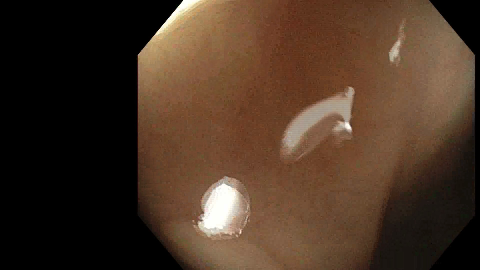

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(input_arr[0])

In [ ]:
print(resnet_model(X_test[0:1]))

tf.Tensor([[0.00015498]], shape=(1, 1), dtype=float32)


## Step 3: K-cross validation + Train last 2 layers

In [ ]:
input_list = []
label_list = []
INPUT_PATH = '/content/class-dataset'

for file in os.listdir(INPUT_PATH + '/0'):
  img = cv2.imread(INPUT_PATH + '/0/' + file)
  if img is not None:
    img = cv2.resize(img, (480, 270))
    input_list.append(img)
    label_list.append(0)

for file in os.listdir(INPUT_PATH + '/1'):
  img = cv2.imread(INPUT_PATH + '/1/' + file)
  if img is not None:
    img = cv2.resize(img, (480, 270))
    input_list.append(img)
    label_list.append(1)

In [ ]:
input_arr = np.array(input_list)
label_arr = np.array(label_list)

In [ ]:
print(input_arr.shape)
print(label_arr.shape)

(1293, 270, 480, 3)
(1293,)


In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(input_arr, label_arr, test_size=0.3, random_state=42)
# print(X_train.shape)

acc_per_fold = []
loss_per_fold = []

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1
for train, test in kfold.split(input_arr, label_arr):
  resnet_model = Sequential()

  pretrained_model= tf.keras.applications.resnet50.ResNet50(include_top=False,
                    input_shape=(270, 480, 3),
                    pooling='avg',classes=2,
                    weights='imagenet')
  for layer in pretrained_model.layers[:-5]:
    layer.trainable=False  

  resnet_model.add(pretrained_model)

  resnet_model.add(Flatten())
  resnet_model.add(Dense(512, activation='relu'))
  resnet_model.add(Dense(1, activation='sigmoid'))

  print(resnet_model.summary())

  resnet_model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

  history = resnet_model.fit(input_arr[train], label_arr[train], epochs=20)

  scores = resnet_model.evaluate(input_arr[test], label_arr[test])
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 2,104,321
Non-trainable params: 22,532,992
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
33/33 [==============================] - 24s 523ms/step - loss: 0.5493 - accuracy: 0.8037
Epoch 2/20
33/33 [==============================] - 16s 479ms/step - loss: 0.1335 - accuracy: 0.9526
Epoch 3/20
33/33 [==============================] - 16s 480ms/step - loss: 0.0679 - accuracy: 0.9758
Epoch 4/20
33/33 [==============================] - 16s 480ms/step - loss: 0.0763 - accuracy: 0.9642
Epoch 5/20
33/33 [==============================] - 16s 481ms/step - loss: 0.0388 - accuracy: 0.9865
Epoch 6/20
33/33 [==============================] - 16s 481ms/step - loss: 0.0386 - accuracy: 0.9826
Epoch 7/20
33/33 [==============================] - 16s 481ms/step - loss: 0.0604 - accuracy: 0.9758
Epoch 8/20
33/33 [==============================] - 16s 479ms/step - loss: 0.0262 - accuracy: 0.9894
Epoch 9/20
33/33 [==============================] - 16s 481ms/step - loss: 0.0165 - accuracy: 0.9952
Epoch 10/20
33/33 [==============================] - 16s 481ms/step - loss: 0.0071 - accura